In [1]:
%matplotlib inline
from __future__ import division, print_function, unicode_literals

from pylab import *
from numpy import random
from numpy import fft
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 8]


In [10]:
import numpy.random as ra
def timmer_and_koenig_pds(pds_shape, n_ave=1):
    '''
    Generate a PDS given a pds shape and the total number of counts.
    '''
    n = len(pds_shape)

    # generate normal distributions for the real and imaginary
    # parts of the Fourier Transform, and multiply them for the
    # wanted spectral shape
    pds = 0
    for i in range(n_ave):
        real_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
        img_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
        pds += real_part ** 2 + img_part ** 2

    return pds / n_ave

def timmer_and_koenig(pds_shape):
    '''
    Generate a PDS given a pds shape and the total number of counts.
    '''
    n = len(pds_shape)

    # generate normal distributions for the real and imaginary
    # parts of the Fourier Transform, and multiply them for the
    # wanted spectral shape
    real_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
    img_part = ra.normal(0, 1, n) * np.sqrt(pds_shape * 0.5)
    # create the positive frequencies of the FT
    half_ft = np.zeros(n, complex)
    for bin in range(0, n):
        half_ft[bin] = complex(real_part[bin], img_part[bin])
    half_ft[-1] = complex(real_part[-1], 0)

    # create the negative frequencies of the FT by reversing the
    # positive part and taking the complex conjugate
    mirror_half_ft = half_ft[::-1].conjugate()
    # the full FT is the concatenation of the negative part, the 0Hz element
    # and the positive part
    ft = np.concatenate(
        (np.array([complex(0., 0.)]),
         half_ft, mirror_half_ft[1:]))

    return np.array(ft)

from astropy.modeling.models import Lorentz1D

frequencies = np.arange(0, 100, 0.01)


# Aperiodic Timing

## Contents

* Not only coherent pulsations

* Optimizing your binning

* Significance

* A full analysis of X-ray timing data

## Not only coherent pulsations

In general, the power spectra of accreting systems are not as simple as the "white noise + coherent peak" we saw in the first exercise.

There is usually a combination of broad and quasi-coherent noise features that carry an interest in themselves. For example:

+ Low-frequency powerlaw or broken-powerlaw noise

+ Low-frequency Quasi-periodic oscillations (LF QPOs)

+ High-frequency Quasi-periodic oscillations (HF QPOs, kHz QPOs)

All of these features are related between them (frequencies are correlated) and they are good tracers of the spectral state of the source. Power spectra are generally modelled as combinations of Lorentzian curves, whose Q factor $Q=A/W$ (A is the amplitude, W is the width) distinguishes between quasi-periodic oscillations and broadband noise. Different authors use different conventions, but in general $Q \gtrsim 5$ indicates a QPO.

Moreover, they are often associated with physical properties of the sources, like:

+ Keplerian frequencies

+ Relativistic oscillations

+ Beats

[[ ADD PLOTS FROM PAPERS!!! ]]

Detecting and characterizing timing properties of the sources is thus extremely interesting and important. Even more, if we join timing and spectral properties to tackle the same observables with independent methods.

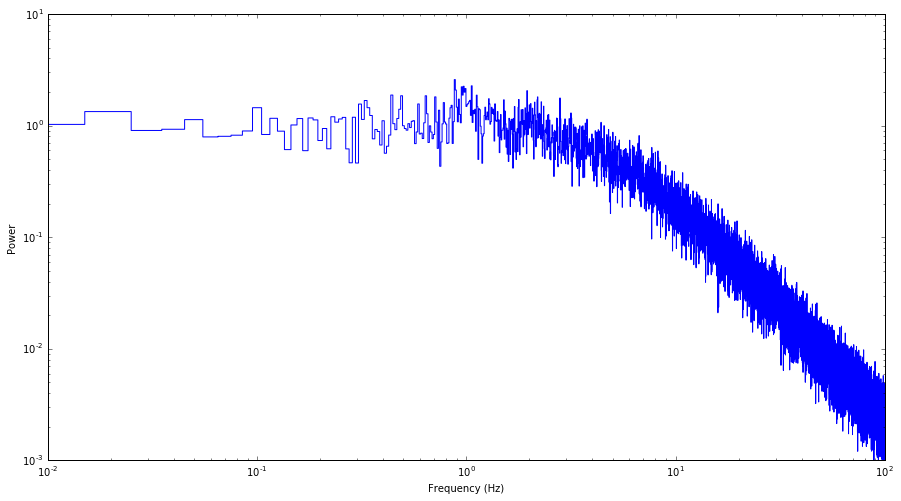

In [17]:
red_noise = Lorentz1D(x_0=0, amplitude=1, fwhm=10)
qpo = Lorentz1D(x_0=1, amplitude=1, fwhm=0.2)
qpo_harm = Lorentz1D(x_0=2, amplitude=0.5, fwhm=0.2)
qpo_hf = Lorentz1D(x_0=30, amplitude=0.01, fwhm=1)

shape_fun = red_noise + qpo + qpo_harm + qpo_hf

pds = timmer_and_koenig_pds(shape_fun(frequencies), n_ave=10)

plt.loglog(frequencies, pds, drawstyle="steps-mid")

plt.ylim([1e-3, None])
xlabel("Frequency (Hz)")
ylabel("Power")

## Optimizing your Binning

We see that this spectrum is very noisy. The features do not "stand out", in particular the one at high frequencies. Binning helps to make them more evident.

(0.001, 10.0)

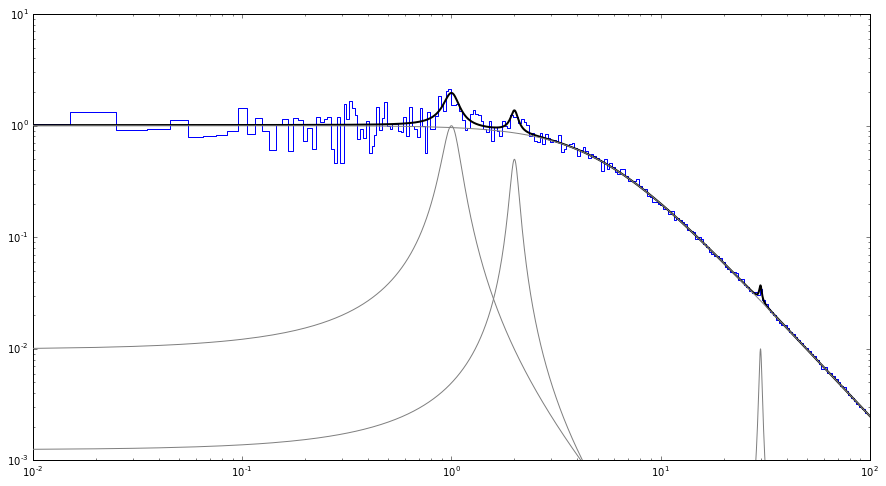

In [18]:
import maltpynt as mp

retval = mp.rebin.geom_bin(frequencies, pds, 1.03)

plt.loglog(frequencies, shape_fun(frequencies), zorder=10, color="k", lw=2)
plt.loglog(frequencies, qpo(frequencies), zorder=10, color="grey")
plt.loglog(frequencies, qpo_harm(frequencies), zorder=10, color="grey")
plt.loglog(frequencies, qpo_hf(frequencies), zorder=10, color="grey")

plt.loglog(frequencies, red_noise(frequencies), zorder=10, color="grey")

flo, fhi, pds_reb = retval.flo, retval.fhi, retval.pds
freq_reb = (fhi + flo) / 2

plt.loglog(freq_reb, pds_reb, drawstyle="steps-mid")
plt.ylim([1e-3, None])



See now as all QPOs stand out clearly from the broadband noise.

A good binning should improve the statistics without averaging too much signal with noise. In practice, it is often a trial-and-error procedure.